In [1]:
#importing dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests
import json
from pprint import pprint
from datetime import datetime
import numpy as np

# Setting path to import Csv files.
auto_insurance_to_load = Path("Resources/AutoInsurance.csv")

# Reading CSV files and transforming into Dataframe.
auto_insurance_df = pd.read_csv(auto_insurance_to_load)

# # set the API URL. 
url_cali = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=6&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_ariz = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=4&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_wash = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=53&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_ore = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=41&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_nev = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=32&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"

In [2]:
# Extracting data from Json file. 
response = requests.get(url_cali).json()
response_one = requests.get(url_ariz).json()
response_two = requests.get(url_nev).json()
response_three =  requests.get(url_wash).json()
response_four =  requests.get(url_ore).json()

In [3]:
#filtering data which is required for our analysis.
data = response['Results'][0]
data_one = response_one['Results'][0]
data_two = response_two['Results'][0]
data_three = response_three['Results'][0]
data_four = response_four['Results'][0]

In [4]:
# Convert the cities accident data into a Pandas DataFrame
cali_df = pd.DataFrame(data)
ariz_df = pd.DataFrame(data_one)
nev_df = pd.DataFrame(data_two)
wash_df = pd.DataFrame(data_three)
ore_df = pd.DataFrame(data_four)

In [5]:
#combined all states accident data into one dataframe. 
combined_df = pd.concat([cali_df, ariz_df, nev_df, wash_df, ore_df], ignore_index=True)
combined_df.sample(10)

,CountyName,CrashDate,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles
264,PLACER (61),/Date(1297971900000-0500)/,1,0,2,60266,6,California,2
176,KERN (29),/Date(1296552900000-0500)/,1,0,2,60178,6,California,1
1041,LOS ANGELES (37),/Date(1296820500000-0500)/,1,1,1,61045,6,California,1
1038,YUBA (115),/Date(1307661660000-0400)/,1,0,3,61042,6,California,2
3617,SNOHOMISH (61),/Date(1297803000000-0500)/,1,1,1,530029,53,Washington,1
1977,RIVERSIDE (65),/Date(1316309040000-0400)/,2,0,4,61983,6,California,1
2505,SACRAMENTO (67),/Date(1315567980000-0400)/,1,0,3,62512,6,California,2
3601,PIERCE (53),/Date(1296111540000-0500)/,1,0,2,530013,53,Washington,1
433,CONTRA COSTA (13),/Date(1300597500000-0400)/,1,0,1,60435,6,California,1
2087,FRESNO (19),/Date(1319590500000-0400)/,1,0,3,62093,6,California,2


In [6]:
# filtering the columns as per our need for analysis. 
unclean_auto_df =  auto_insurance_df[[
                            "State",
                            "Gender",
                            "Coverage",
                            "Education",
                            "Income",
                            "Number of Policies",
                            "Marital Status",
                            "EmploymentStatus",
                            "Policy Type",
                            "Policy",
                            "Renew Offer Type",
                            "Monthly Premium Auto",
                            "Location Code",
                            "Total Claim Amount",
                            "Vehicle Class", 
                            "Vehicle Size",
                            "Customer Lifetime Value"
                            ]]
# deleting first row as it did not have relevant information.
auto_df = unclean_auto_df.drop(index=0)
# removing all rows where income = 0 to clean the dataframe.
income_df = auto_df.loc[auto_df["Income"] != 0]

# checking the correlation between different elements on the dataframe.
income_df[["Income","Monthly Premium Auto","Customer Lifetime Value","Total Claim Amount","Number of Policies",]].corr()

,Income,Monthly Premium Auto,Customer Lifetime Value,Total Claim Amount,Number of Policies
Income,1.000000,-0.012372,0.002915,-0.221879,-0.001324
Monthly Premium Auto,-0.012372,1.000000,0.399491,0.636084,-0.026795
Customer Lifetime Value,0.002915,0.399491,1.000000,0.245464,0.022683
Total Claim Amount,-0.221879,0.636084,0.245464,1.000000,-0.012253
Number of Policies,-0.001324,-0.026795,0.022683,-0.012253,1.000000


## Q -- Determine the Impact of vehicle characteristics on insurance rates

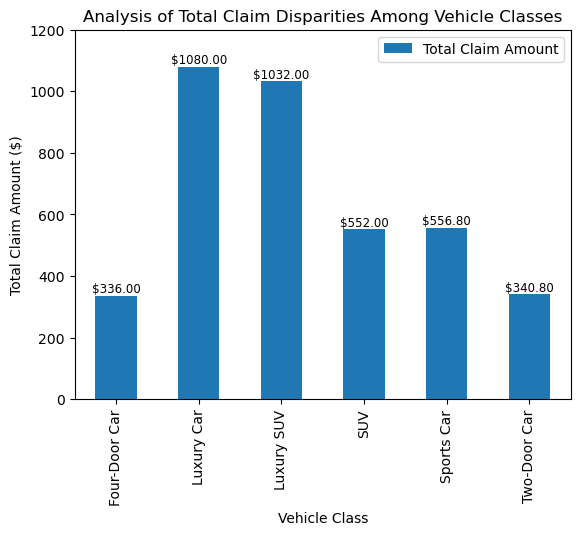

In [7]:
# Bar graph for mean total claim amount vs. Vehicle Class
# Grouping the median Total claim amount by Vehicle Class 
grouped_df = pd.DataFrame(auto_df.groupby('Vehicle Class')['Total Claim Amount'].median())

# Resetting the index so vehicle class is one of the column 
grouped_df = grouped_df.reset_index()

# Plotting the bar graph
ax = grouped_df.plot("Vehicle Class", "Total Claim Amount", kind="bar", ylabel="Total Claim Amount ($)")

# Add title to the bar graph 
plt.title("Analysis of Total Claim Disparities Among Vehicle Classes")

# Adding labels to the bars
for index, value in enumerate(grouped_df['Total Claim Amount']):
    ax.text(index, value, f"${value:.2f}", ha='center', va='bottom', size=8.5)

plt.ylim(0, 1200)

# Save figure 
plt.savefig("Output/Rachel_total_claim_vs_vehicle_class.png", bbox_inches="tight")
    
# Show plot
plt.show()

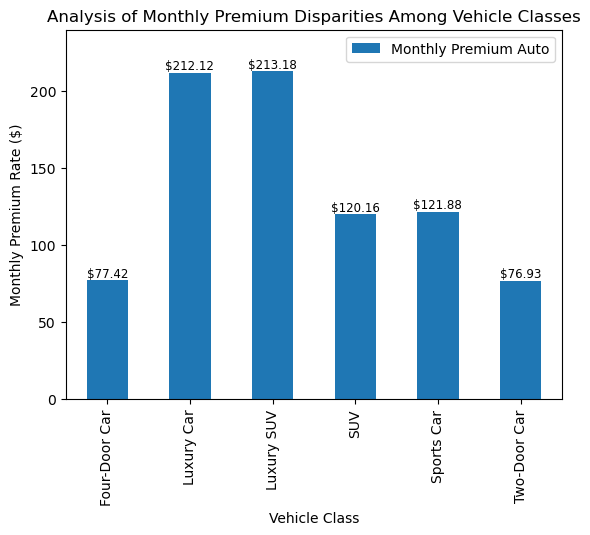

In [8]:
# Bar graph for Median total claim amount vs. Vehicle Class
# Grouping the median monthly premium auto price by Vehicle Class 
grouped_df = pd.DataFrame(auto_df.groupby('Vehicle Class')['Monthly Premium Auto'].mean())

# Resetting the index so vehicle class is one of the column 
grouped_df = grouped_df.reset_index()

# Plotting the bar graph
ax = grouped_df.plot("Vehicle Class", "Monthly Premium Auto", kind="bar", ylabel="Monthly Premium Rate ($)")

# Adding title to the graph 
plt.title("Analysis of Monthly Premium Disparities Among Vehicle Classes")

# Adding labels to the graph & improve appearance of the graph
for index, value in enumerate(grouped_df['Monthly Premium Auto']):
    ax.text(index, value, f"${value:.2f}", ha='center', va='bottom', size=8.5)
plt.ylim(0, 240)

# Save figure 
plt.savefig("Output/Rachel_monthly_premium_vs_vehicle_class.png", bbox_inches="tight")

# Show plot
plt.show()

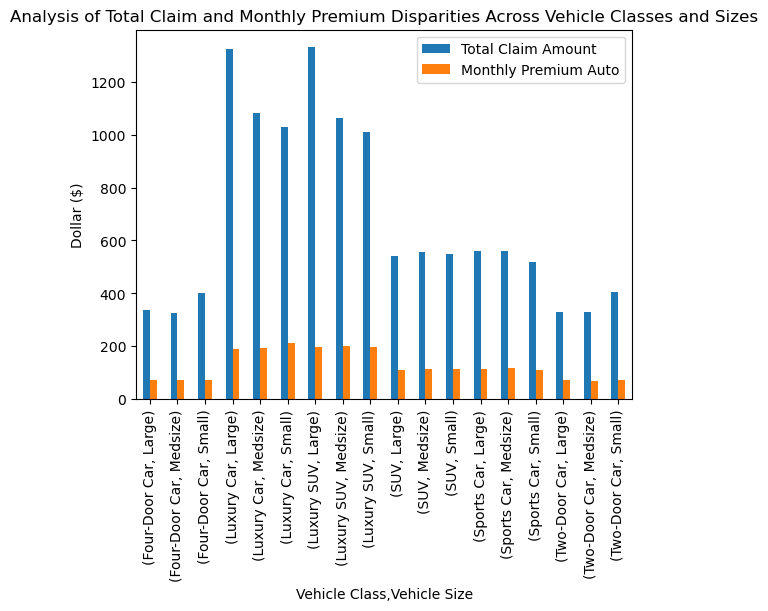

In [9]:
size_class_total = auto_df.groupby(["Vehicle Class", "Vehicle Size"])["Total Claim Amount"].median()
size_class_month = auto_df.groupby(["Vehicle Class", "Vehicle Size"])["Monthly Premium Auto"].median()

# Merging the total claim amount & monthly premium auto dataset 
df = pd.merge(size_class_total, size_class_month, on=["Vehicle Class", "Vehicle Size"])

# Plotting bar graph 
df.plot(kind="bar", ylabel="Dollar ($)")

# Add title to the bar graph 
plt.title("Analysis of Total Claim and Monthly Premium Disparities Across Vehicle Classes and Sizes")

# Setting legend
plt.legend(loc="best")

# Save figure 
plt.savefig("Output/Rachel_totalclaim_&_monthlypremium_vs_class & size.png", bbox_inches="tight")

# Show plot
plt.show()

## Written Analysis

Regarding Vehicle Class, Total Claim Amount, and Monthly Premium Rate:
- Luxury cars and SUVs exhibit the highest total claim amounts compared to other vehicle classes. This phenomenon is likely attributable to the higher initial cost of these vehicles, resulting in elevated repair expenses. 

In relation to Vehicle Size, Total Claim Amount, and Monthly Premium Rate:
- Analysis of the monthly premium rate reveals no significant variation across different vehicle sizes.
- Examination of total claim amounts indicates that smaller vehicles tend to incur higher claim amounts. This trend may be attributed to their increased susceptibility to theft, owing to their lower cost and higher market demand, as supported by existing research.

Analysis of Vehicle Size and Class in Relation to Total Claim Amount and Monthly Premium Rate:
- Based on the analysis of vehicle size and class in relation to total claim amount, it is observed that across most vehicle classes, larger vehicles tend to have higher total claim amounts. This trend may be attributed to the potential for larger vehicles to cause more extensive damage, resulting in increased claim amounts.

 ## Q -- Is there correlation between Total Claim amount/Customer Lifetime Value versus Monthly premiums? If so, is it strong enough to create a prediction model?

In [10]:
# Defined function for linear regression and scatter plot
def linear_regression(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    return print(f"The R-value is {rvalue**2}"),plt.scatter(x_values,y_values,color="gold",edgecolors="black",alpha=0.3),plt.plot(x_values,regress_values,"b-"),plt.annotate(line_eq,(min(x_values) + 50,max(y_values)),fontsize=10,color="red")

The R-value is 0.1595930222935034


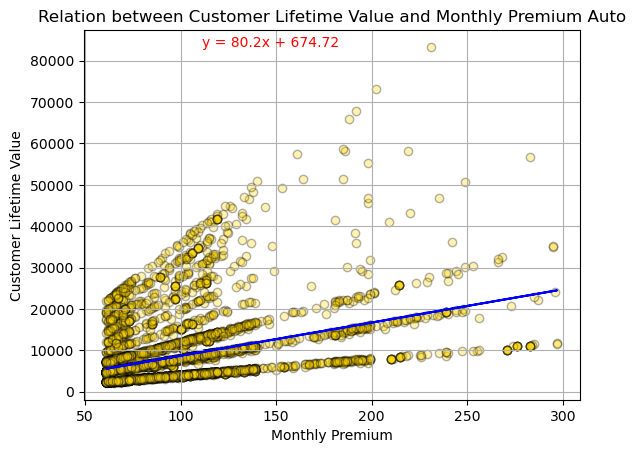

In [11]:
# defining variables to put into function
x_values = income_df["Monthly Premium Auto"]
y_values = income_df["Customer Lifetime Value"]
linear_regression(x_values,y_values)

# adding plot specific detail that cant be dynamic using function.
plt.xlabel("Monthly Premium")
plt.ylabel("Customer Lifetime Value")
plt.title("Relation between Customer Lifetime Value and Monthly Premium Auto")
plt.grid(True)
plt.savefig("Output/Adi_Scatter1.png")

The R-value is 0.4046024951347791


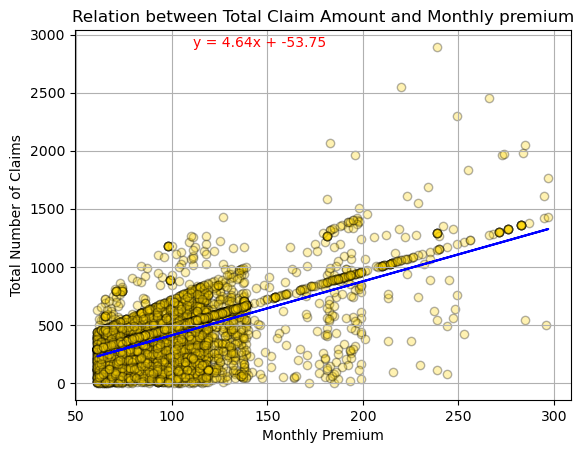

In [12]:
# defining variables to put into function
x_values = income_df["Monthly Premium Auto"]
y_values = income_df["Total Claim Amount"]
linear_regression(x_values,y_values,)
# adding plot specific detail that cant be dynamic using function.
plt.xlabel("Monthly Premium")
plt.ylabel("Total Number of Claims")
plt.title("Relation between Total Claim Amount and Monthly premium")
plt.grid(True)
plt.savefig("Output/Adi_Scatter2.png")

### Written Analysis: 


The Relation between Customer Lifetime Value and Monthly Premiums is positive which indicates that a higher lifetime value tends to have a higher monthly Premium . The R-value of 0.1595 suggests that although the relation is positive there are possibly multiple other factors that could be impacting the monthly insurance premium. Therefore, in order to build a predictive model more data and advanced techniques would need to be implemented.

There is a positive corelation between Total Number of claims & Monthly Premium indicated by its R value of 0.4046. This may not indicate a highly predictive model but it still provides a significant amount of explanatory power. This model can be used to gain valuable insights, make informed decisions, and guide further improvements. Continuously refining the model and incorporating more data and advanced techniques can help enhance its predictive capabilities. This model can be a good starting point but would need more sophistication to be accurate in its prediction.

## Q --  Which state has the most number of insurance claims and why? 

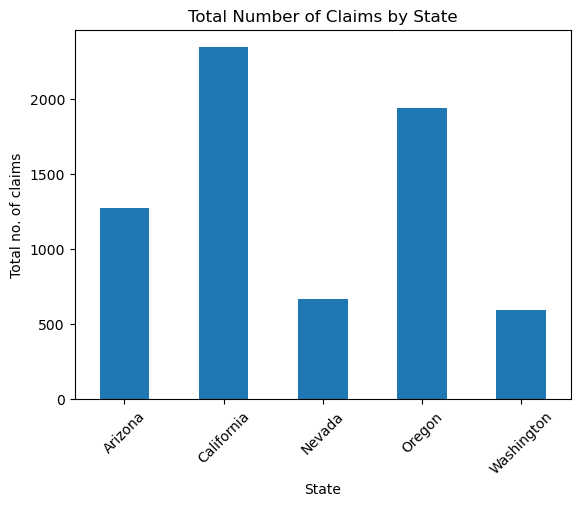

In [13]:
bar_df = income_df.groupby('State')['Total Claim Amount'].count()

bar_df.plot(kind='bar', ylabel='Total no. of claims')
plt.title('Total Number of Claims by State')
plt.xticks(rotation=45)


plt.savefig("Output/Jin_Dhruv_Total_Number_of_Claims_by_State.png")

plt.show()

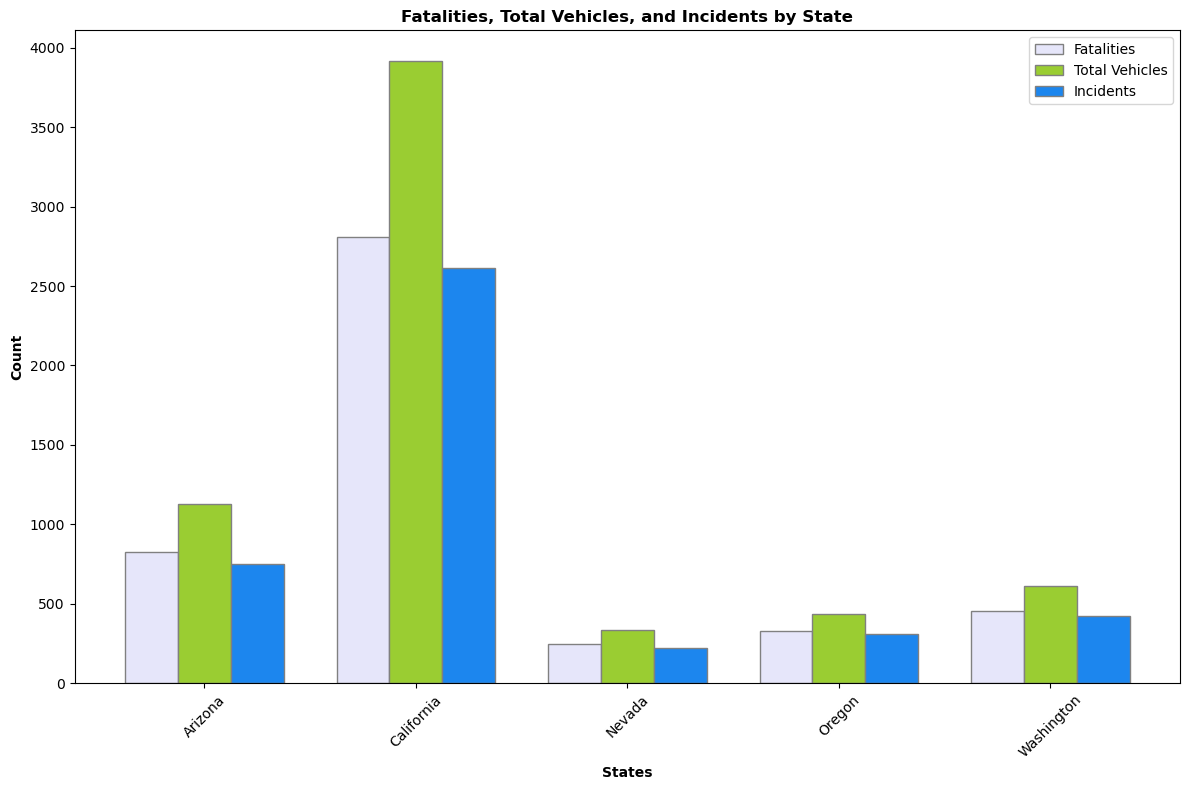

In [14]:
grouped_df = combined_df.groupby('StateName').agg({
    'St_Case': 'count',
    'Fatals': 'sum',
    'TotalVehicles': 'sum',
    'Persons': 'sum'
}).reset_index()
grouped_df

states = grouped_df['StateName']
num_states = len(states)

fatals = grouped_df['Fatals']
total_vehicles = grouped_df['TotalVehicles']
st_case = grouped_df['St_Case']

bar_width = 0.25

r1 = np.arange(num_states)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(r1, fatals, color='#E6E6FA', width=bar_width, edgecolor='grey', label='Fatalities')
ax.bar(r2, total_vehicles, color='#9ACD32', width=bar_width, edgecolor='grey', label='Total Vehicles')
ax.bar(r3, st_case, color='#1C86EE', width=bar_width, edgecolor='grey', label='Incidents')

ax.set_xlabel('States', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Fatalities, Total Vehicles, and Incidents by State', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(num_states)])
ax.set_xticklabels(states)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("Output/Jin_Dhruv_Total_Vehicles_and_Incidents_by_State.png")

plt.show()


### Written Analysis

California's status as the state with the highest number of claims, traffic incidents, vehicles involved, fatalities, and individuals affected can be largely attributed to its immense population and significantly higher population density compared to other states. With over 39 million residents and bustling urban centers like Los Angeles and San Francisco, California experiences substantial vehicular activity on its extensive road networks. The sheer volume of vehicles, combined with various demographic and geographic factors, contributes to a higher frequency of traffic incidents and their associated impacts, including fatalities and injuries.

## Q -- Determine the impact of Driver Characteristics on monthly insurance premiums.

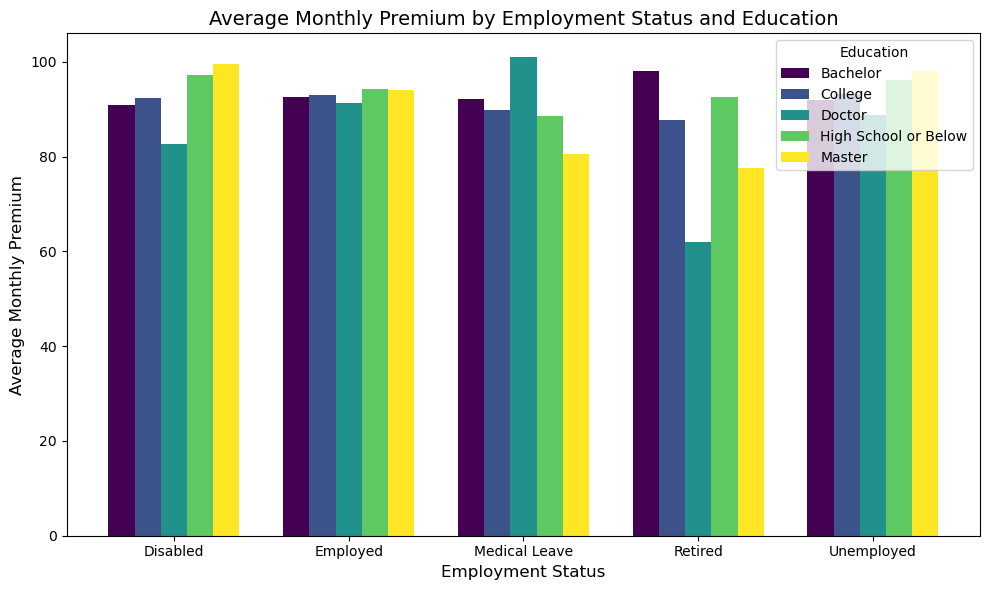

In [15]:
# Grouping the data by EmploymentStatus and Education, and calculating mean Monthly Premium Auto
grouped_df = auto_df.groupby(['EmploymentStatus', 'Education'])['Monthly Premium Auto'].mean().reset_index()

# We need to pivot 'grouped_df' to get 'Education' as columns.
pivot_df = grouped_df.pivot(index='EmploymentStatus', columns='Education', values='Monthly Premium Auto')

# Now we'll create a bar chart with the pivoted data.
bar_width = 0.15  # Width of the bars
index = np.arange(len(pivot_df.index))  # Array with the number of bars per group
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar for each 'Education' category.
colors = plt.cm.viridis(np.linspace(0, 1, len(pivot_df.columns)))  # Generate colors for each 'Education' category
for i, (column, color) in enumerate(zip(pivot_df.columns, colors)):
    ax.bar(index + i * bar_width, pivot_df[column], bar_width, label=column, color=color)

# Add labels and title.
ax.set_xlabel('Employment Status', fontsize=12)
ax.set_ylabel('Average Monthly Premium', fontsize=12)
ax.set_title('Average Monthly Premium by Employment Status and Education', fontsize=14)
ax.set_xticks(index + bar_width / 2 * (len(pivot_df.columns) - 1))
ax.set_xticklabels(pivot_df.index)

# Adding the legend and making it look nice.
ax.legend(title='Education')

# Show the plot.
plt.tight_layout()
plt.savefig("Output/Devi_Monthly Premium by Employment and Education.png")
plt.show()

### Written Analysis

Above graph shows the relationship between Employment status and Education with monthly premium. People with a Doctors, Bachelors or a Masters degree seem to be having a higher premium irrespective of the employment status. Of all the categories, people in the retired group have slightly lesser premium whereas people who are employed seem to be paying a consistent amount as monthly premium for all education levels. 

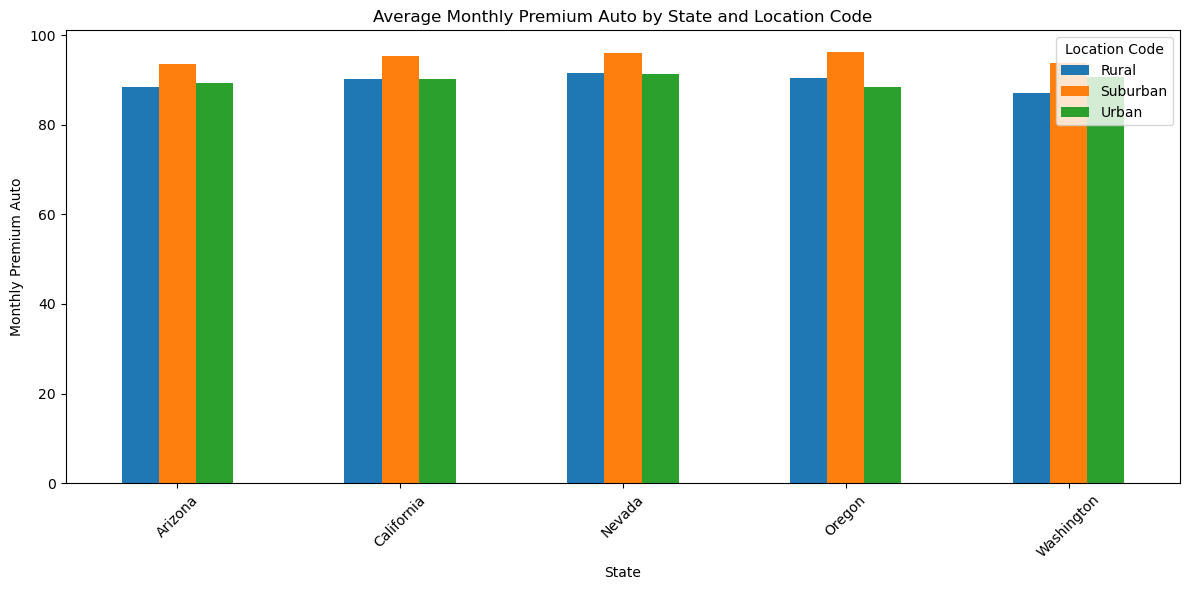

In [16]:
# Grouping data by "State" and "Policy Type," and calculating the mean of "Monthly Premium Auto"
state_policy_premium_mean = auto_df.groupby(["State", "Location Code"])["Monthly Premium Auto"].mean()

# Reshaping the data into a pivot table
state_policy_premium_pivot = state_policy_premium_mean.unstack()

# Creating the bar chart
plt.figure(figsize=(12, 6))
state_policy_premium_pivot.plot(kind="bar", ax=plt.gca())
plt.xlabel("State")
plt.ylabel("Monthly Premium Auto")
plt.title("Average Monthly Premium Auto by State and Location Code")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("Output/Devi_Monthly Premium by State and Location code.png")
plt.show()

### Written Analysis

Above graph shows the relationship between state and location code against monthly premium for 5 different states namely AZ, CA, NV, OR, WA. Though the monthly premium seems to be more or less similar across all states, people living in sub-urban neighbourhoods pay a higher premium than the people living in rural and urban neighbourhoods. This can be accounted to the fact that people living in sub-urban neighbourhoods may have to drive to urban areas of the city for their work, other purposes etc.